# STAGE 4: ANALYZE - Trip Counts and Trip Duration by Rider Type by Bike Type

#### Ingest the big csv to get ready for analysis

In [4]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

dtypes = {'ride_id': 'str', 'rideable_type': 'category',  'start_station_id': 'category', 
            'end_station_id': 'category', 'member_casual': 'category'}
usecols = ['ride_id', 'rideable_type',  #'start_station_id', 'end_station_id',
             'member_casual','started_at','ended_at'#,'start_lat','start_lng','end_lat','end_lng'
          ]

# this is a function to read the trip files,
def read_csv_to_df(filename, dtype, usecols):
    df = pd.read_csv(filename, parse_dates=['started_at','ended_at'], dtype = dtype, usecols=usecols)
    print (filename,df.memory_usage(deep=True).sum()/1e+6, " Mbytes")
    return df

dfbig = read_csv_to_df('dfbig.csv', dtypes, usecols)

dfbig.csv 918.326176  Mbytes


#### Aggregate Ride Count by month by ride type and rider type

In [5]:
def yearmonth(d):
    from datetime import datetime
    return d.strftime('%Y%m')

dfbig['Ym']=dfbig['started_at'].apply(yearmonth)

dfbigplot = dfbig.groupby(['rideable_type','Ym','member_casual'])['ride_id'].count()
dfbigplot.name ='ride_count'
dfbigplot = dfbigplot.reset_index()

In [6]:
# dfbigplot.to_csv('ride_count_by_Ym_by_rideabletype_bymembertype.csv')

#### Plot Stack plot for Rider trip count by Bike Type

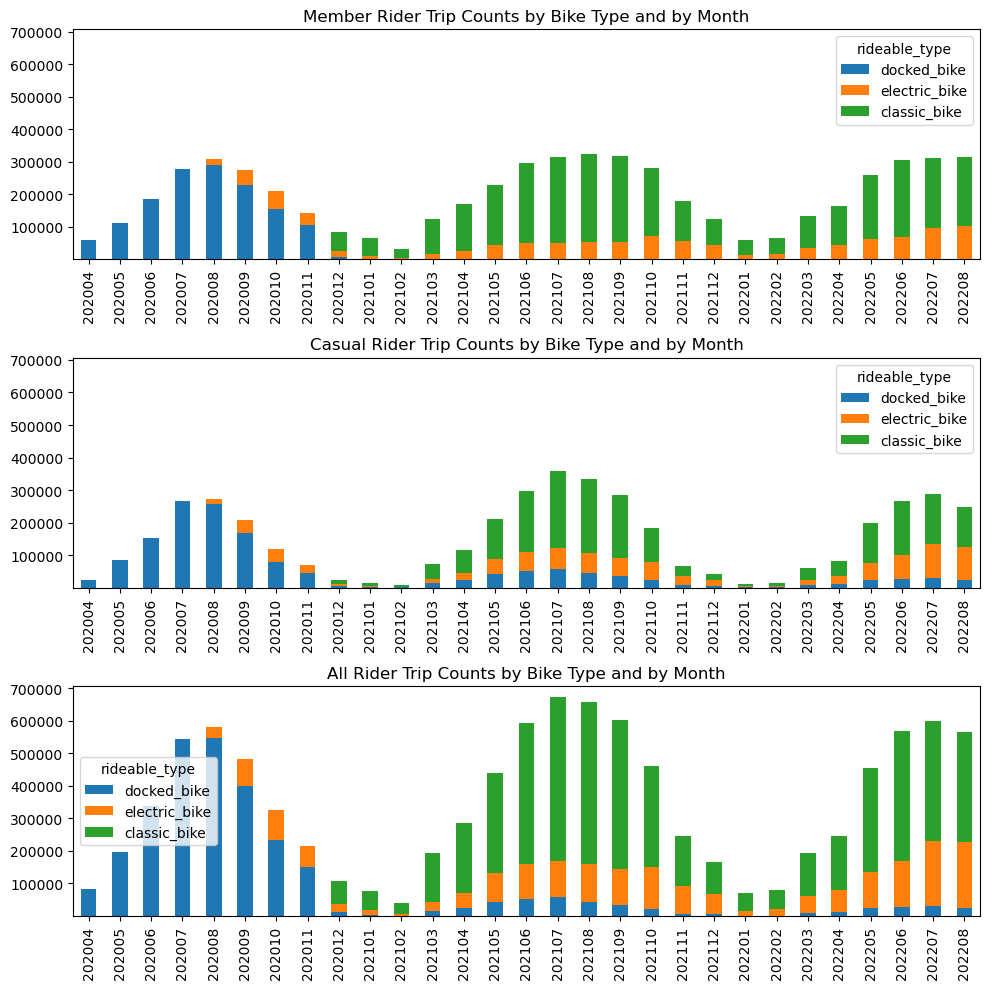

In [7]:
fig, ax = plt.subplots(3, figsize=[10,10], sharey=True)
dfbigplot[dfbigplot['member_casual']=='member'].groupby(['Ym', 'rideable_type'])['ride_count'].sum().unstack().\
plot(title ='Member Rider Trip Counts by Bike Type and by Month', \
     kind='bar', stacked=True, ax=ax[0])

dfbigplot[dfbigplot['member_casual']=='casual'].groupby(['Ym', 'rideable_type'])['ride_count'].sum().unstack().\
plot(title ='Casual Rider Trip Counts by Bike Type and by Month', \
     kind='bar', stacked=True, ax=ax[1])

dfbigplot.groupby(['Ym', 'rideable_type'])['ride_count'].sum().unstack().\
plot(title ='All Rider Trip Counts by Bike Type and by Month', \
     kind='bar', stacked=True, ax=ax[2])
ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('')
fig.tight_layout()
plt.savefig('./Figures/Ride_Count_by_BikeType_RiderType.png', bbox_inches='tight')

##### Observations:

    - Rideable type docked_bike was intitially the only type but is getting phased out. The casual members are slower to phase out docked_bike type. 
    - Classic_bike becomes most popular but electric_bike is gaining popularity. 
    - It is surprising that annual member which I perceive as communters choose to use classic bike over electric in comparison to casual members. Need to explore further on the motivation of choosing bike types such as bike for health, or leisure, or cost/ availability factors. (It is beyond scope for this analysis, but in reality, it is a import question.)
    - The number of rides corresponds to seasons. The rides peaked in July and August months and lowest during December through February. The ride number patterns are very similar between Casual and Annual members.
##### Conclusion:
    The ride counts between memembr and casual rider are actually quite similar. This is good news, since that also means there are many casual riders that are already familiar with using bike sharing services. We just need to find out further what will motivate them to commit to membership.
    

#### Aggregate Ride Duration by month by ride type and rider type

In [9]:
import datetime
dfbig['duration']= (dfbig['ended_at']-dfbig['started_at']).apply(datetime.timedelta.total_seconds)/60

dfduration_stats = dfbig.drop(['ride_id','started_at','ended_at'], axis=1).groupby(['rideable_type','member_casual','Ym']).describe()

dfduration_stats1 = dfduration_stats.reset_index()

dfduration_stats1.columns = ['rideable_type','member type','Ym','count','mean','std','min','25%','50%','75%','max']

dfduration_stats1.head(1)

,rideable_type,member type,Ym,count,mean,std,min,25%,50%,75%,max
0,docked_bike,casual,202004,23311.0,41.094393,87.295557,0.0,14.658333,25.183333,42.516667,1726.816667


In [15]:
dfduration_stats_0_100=pd.melt(dfduration_stats1, id_vars=['rideable_type','member type','Ym'], value_vars=['min', '50%','max'])

In [11]:
dfduration_stats_25_75=pd.melt(dfduration_stats1, id_vars=['rideable_type','member type','Ym'], value_vars=['25%', '50%','75%'])

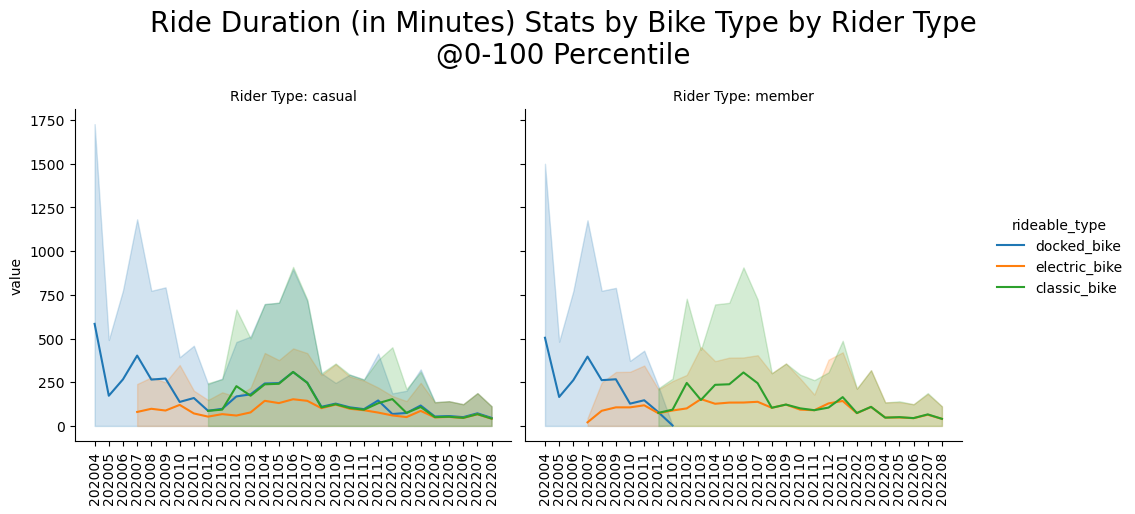

In [17]:
g=sns.relplot(
    data=dfduration_stats_0_100, x="Ym", y="value", col= "member type"
     , kind="line", hue="rideable_type"
)
g.fig.suptitle('Ride Duration (in Minutes) Stats by Bike Type by Rider Type\n @0-100 Percentile ', size=20)
g.set_titles("Rider Type: {col_name}")
g.tight_layout(w_pad=0)
g.set_xticklabels(rotation=90)
g.set_xlabels("")
plt.savefig('./Figures/Ride_Duration_by_BikeType_RiderType_minmax.png', bbox_inches='tight')             

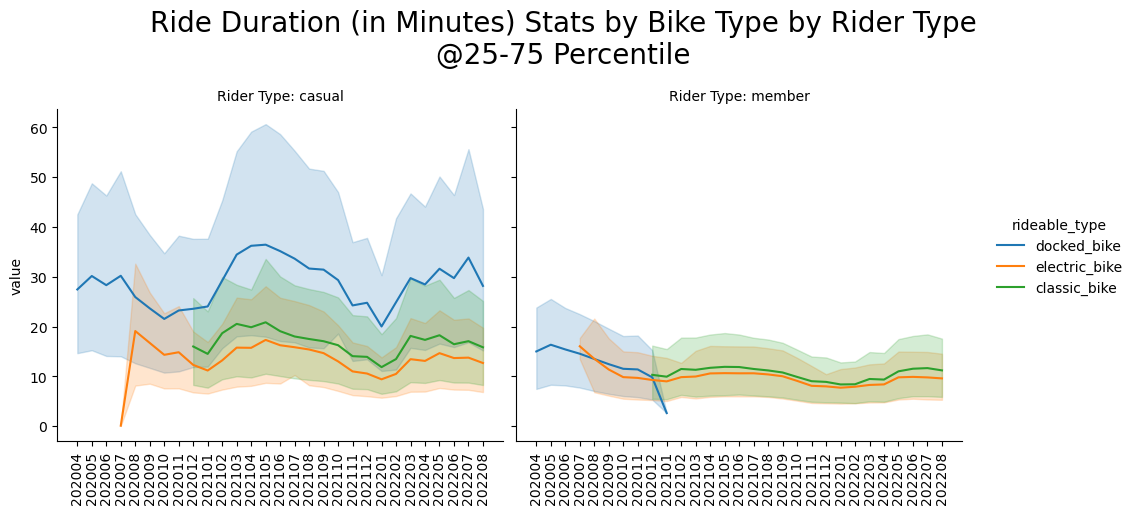

In [18]:
g=sns.relplot(
    data=dfduration_stats_25_75, x="Ym", y="value", col= "member type"
     , kind="line", hue="rideable_type"
)
g.fig.suptitle('Ride Duration (in Minutes) Stats by Bike Type by Rider Type\n @25-75 Percentile ', size=20)
g.set_titles("Rider Type: {col_name}")
g.tight_layout(w_pad=0)
g.set_xticklabels(rotation=90)
g.set_xlabels("")
plt.savefig('./Figures/Ride_Duration_by_BikeType_RiderType_25_75.png', bbox_inches='tight')  

##### Observations:

  - Compare left and right figures for 0-100% (min and max), they look very similar. Meaning the maximum length of trips are not good differentiators for the rider types. But we will need to observe them in the next analysis when further dividing the trips into hour in the day and day of the week etc.
  - When looking at 25-75% of the duration stats, we see now that majority of the trips taken by members are shorter and varying less than the casual. This is likely the members use the bike for commuting so the distances are more constant. Whereas for casual riders, the ride purpose vary a lot more hence different length.
  
##### Conclusion:
    The ride duration stats shows that casual riders have more diverse trip length which differ from member riders who probably use bikes for more similar trips such as commuting and shorter trips.